Using MNIST dataset, we build a simple model for classification then we use different quantization methods to quantize the model and benchmark perofrmance. 

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random


In [3]:
# Device configuration
device = torch.device("cpu")
batch_size = 128

# MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset  = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

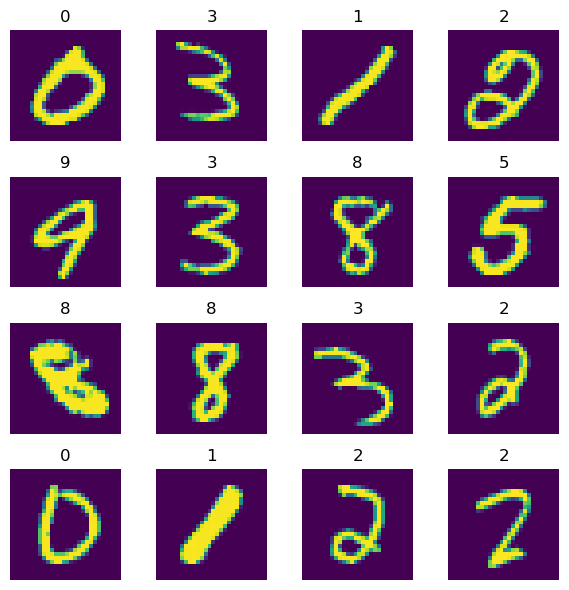

In [4]:
# Load MNIST test dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Select random samples
num_samples = 16
indices = random.sample(range(len(test_dataset)), num_samples)
samples = [test_dataset[i] for i in indices]

# Plot a grid of sample images
plt.figure(figsize=(6, 6))
for idx, (img, label) in enumerate(samples):
    plt.subplot(4, 4, idx + 1)
    plt.imshow(img.squeeze(), interpolation='nearest')
    plt.axis('off')
    plt.title(str(label))
plt.tight_layout()
plt.show()


In [5]:
print(f"input shape {samples[0][0].shape}")
num_labels = 10 # 10 digit classification

input shape torch.Size([1, 28, 28])


In [6]:
# Simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1   = nn.Linear(9216, 128) # see below for calculation
        self.fc2   = nn.Linear(128, num_labels)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x



In [7]:
W = 28
K = 3
P = 0
S = 1
num_channels = 32
output = (W - K + 2 * P) / S + 1  # output size after first conv layer
print(output)

W = output  # second layer
output = (W - K + 2 * P) / S + 1
print(output)

# max pool 
output /= 2 
print(output)

# flattening 
num_channels = 64
print(output * output * num_channels)

26.0
24.0
12.0
9216.0


In [245]:
# Hyperparameters
learning_rate = 0.01
num_epochs = 1  # For demonstration

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [9]:
# Training loop (1 epoch for demonstration)

model.train()
for epoch in range(num_epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

# Evaluation function
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            correct += (pred == target).sum().item()
            total += target.size(0)
    return correct / total

# Evaluate the full-precision model
orig_acc = evaluate(model, test_loader)
print(f"Full-precision test accuracy: {orig_acc * 100:.2f}%")

Epoch 1/1, Loss: 0.2078
Full-precision test accuracy: 92.72%


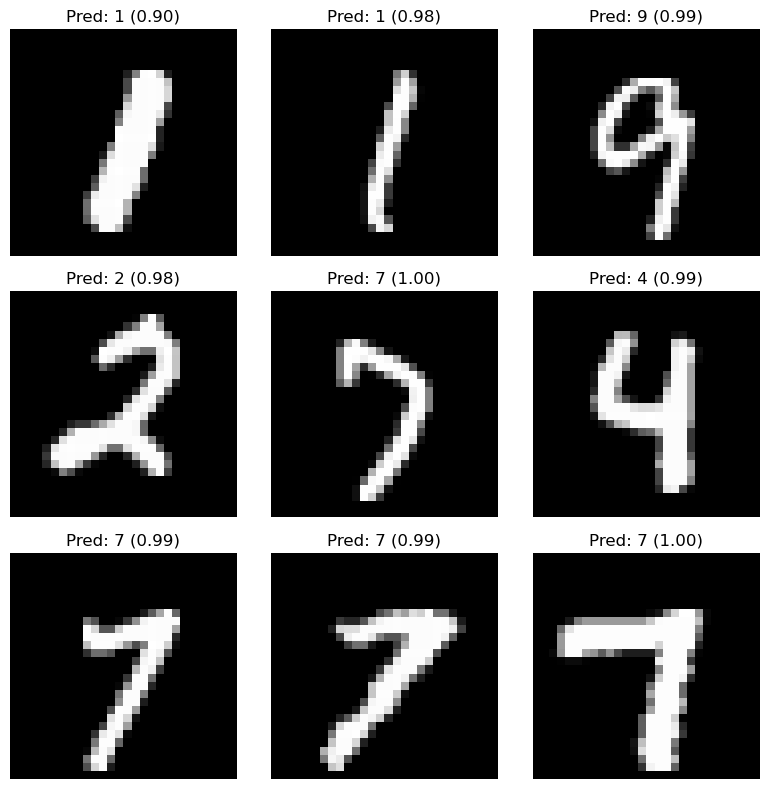

In [10]:
# Choose a few random test samples
num_samples = 9
indices = random.sample(range(len(test_dataset)), num_samples)
samples = [test_dataset[i] for i in indices]

# Prepare data batch
images = torch.stack([img for img, _ in samples]).to(device)
labels = torch.tensor([label for _, label in samples]).to(device)

# Run inference with softmax to get probabilities
model.eval()
with torch.no_grad():
    outputs = model(images)
    probs = F.softmax(outputs, dim=1)
    preds = torch.argmax(probs, dim=1)

# Plot the images with predicted label and probability
plt.figure(figsize=(8, 8))
for idx in range(num_samples):
    img = images[idx].cpu().squeeze()
    true_label = labels[idx].item()
    pred_label = preds[idx].item()
    pred_prob = probs[idx][pred_label].item()

    plt.subplot(3, 3, idx + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f"Pred: {pred_label} ({pred_prob:.2f})")

plt.tight_layout()
plt.show()


# Dyanmic quantization

    - This is a post-training technique. It quantizes the weighs but activation remain in fp32 and only quantized at run time. 
    - quantize_dynamic converts linear layer and con2d weights to int8. 
    - input is fp32, but gets quantized "dynamically" before matrix multiplication. 
    - Matrix multipication is done on quantized weights and quantized activation 
    - the output gets dequantized to fp32 

The inference is fast on CPU because integer matmul is fast. 

Notice that dynamic quantization does not support Conv layers, only linear and LSTMs. 

In [12]:
from torch.quantization import quantize_dynamic
torch.backends.quantized.engine = 'qnnpack'

In [13]:
# Dynamic quantization: quantize weights to int8, keep activations in fp32
quantized_model = quantize_dynamic(
    model, {nn.Linear}, dtype=torch.qint8
)
quantized_model.to(device)

# Evaluate the quantized model
quant_acc = evaluate(quantized_model, test_loader)
print(f"Quantized (dynamic int8) test accuracy: {quant_acc * 100:.2f}%")


[W504 16:56:19.908465000 qlinear_dynamic.cpp:251] Warning: Currently, qnnpack incorrectly ignores reduce_range when it is set to true; this may change in a future release. (function operator())


Quantized (dynamic int8) test accuracy: 92.78%


Performance is almost the same as the original modell in FP32! 

# Benchmarking inference speed and size 

In [16]:
import os 
import time 
# Function to get model size
def get_model_size(model, path="temp_model.pth"):
    torch.save(model.state_dict(), path)
    size = os.path.getsize(path) / 1e6  # in MB
    os.remove(path)
    return size

# Function to measure average inference time
def measure_inference_time(model, inputs, runs=100):
    model.eval()
    with torch.no_grad():
        for _ in range(3):  # Warm-up
            _ = model(inputs)
        start = time.time()
        for _ in range(runs):
            _ = model(inputs)
        end = time.time()
    return (end - start) / runs

# Sample input for timing
images, _ = next(iter(test_loader))
images = images.to(device)


# Compare model sizes
original_size = get_model_size(model)
quantized_size = get_model_size(quantized_model)

# Compare inference speeds
original_time = measure_inference_time(model, images)
quantized_time = measure_inference_time(quantized_model, images)

print(f"original_size {original_size}")
print(f"quantized_size {quantized_size}")
print(f"original_time {original_time}")
print(f"quantized_time {quantized_time}")


original_size 4.803063
quantized_size 1.261621
original_time 0.013543596267700195
quantized_time 0.013466949462890626


Well good news the model is over four times slower. But, how come quantized model is slower? Likely the time spent to quantize and dequntize is outweighing the faster matmuls. And, it could be the speed from int matmuls is also supported on certain CPUs and not mine. Also, our model is pretty small to begin with. Perhaps if we use even a larger batch size we could get better performance from quantized model. Instead of guessing, let's use torch profiler.  

In [18]:
import torch.profiler

def profile_inference(model, inputs):
    model.eval()
    with torch.no_grad():
        with torch.profiler.profile(
            activities=[torch.profiler.ProfilerActivity.CPU],
            record_shapes=True,
            with_stack=True,
            profile_memory=True
        ) as prof:
            _ = model(inputs)

    print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=15))

# Example usage
print("Original")
profile_inference(model, images)  # For original
print("*************")
print("Quantized")
profile_inference(quantized_model, images)  # For quantized


Original
-------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                 Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                         aten::conv2d         0.03%       3.541us        50.73%       6.992ms       3.496ms      28.56 Mb           0 b             2  
                    aten::convolution         0.04%       5.541us        50.70%       6.988ms       3.494ms      28.56 Mb           0 b             2  
                   aten::_convolution         7.44%       1.025ms        50.66%       6.983ms       3.491ms      28.56 Mb           0 b             2  
    aten::_nnpack_spatial_convolution        43.21%       5.955ms        43.21%

# Profiling 

Take a look at this operation : aten::_nnpack_spatial_convolution

This is Pytorch using optimized path for CPU convolution to speed things. This is faster for the quantized model by over 2 times. You can see where the quntized layers are inserted here. As you can see there are a few additional operation here like aten::min  and aten::max. These values are used to to find the scale and zero point of quantization. 

Each layer dynamically looks at the scale of the activation per batch. We know the Min and Max of int8 is -128 and 127. We can inspect these values from one of the layers more closely. 

# Hook 

Let's add a hook into the quantized model and inspect the scale and zero point. What's a hook in pytorch? 

Hook is a way to interpret and modify the input, output and any intermidate state during forward and backward prop. We can use it to run codes on our model during forward prop on a layer or check the gradients in backward prop. 

A forward hook looks like this 

    - hook_fn(module, input, output)

module is where the hook is attached and input and output are tensors to and from the module. Here we're going to check the activation during forward pass. This is helpful for debugging as we can create custom operation to extend behavior of the model. The hook function is executed everytime the model goes through a forward. We're going to use it to calculate the min/max/scale and zero point of the input tensor. 

In [20]:
def quantization_info_hook(module, input, output):
    act = input[0]
    min_val, max_val = act.min().item(), act.max().item()
    scale = (max_val - min_val) / 255 if max_val != min_val else 1.0
    zero_point = int(round(-min_val / scale)) if scale != 0 else 0
    print(f"[{module.__class__.__name__}] Activation min/max: ({min_val:.4f}, {max_val:.4f})")
    print(f"Quantization scale: {scale:.6f}, zero_point: {zero_point}")


Now let's register the hook. We're going to register it on quantized layer of the model using register_forward_hook. This gets it called on every run. 

In [43]:
for name, module in quantized_model.named_modules():
    if isinstance(module, nn.quantized.dynamic.Linear):
        module.register_forward_hook(quantization_info_hook)

Let's trigger the hook

In [45]:
_ = quantized_model(images)  # This triggers the hook

[Linear] Activation min/max: (0.0000, 12.6261)
Quantization scale: 0.049514, zero_point: 0
[Linear] Activation min/max: (0.0000, 16.5340)
Quantization scale: 0.064839, zero_point: 0


In [47]:
min_val = 0
max_val = 14.16
scale = (max_val - min_val) / 255
zero_point = int(-min_val / scale)
print(scale, zero_point)

0.05552941176470588 0


# PTQ with Static quantization 

https://pytorch.org/blog/quantization-in-practice/
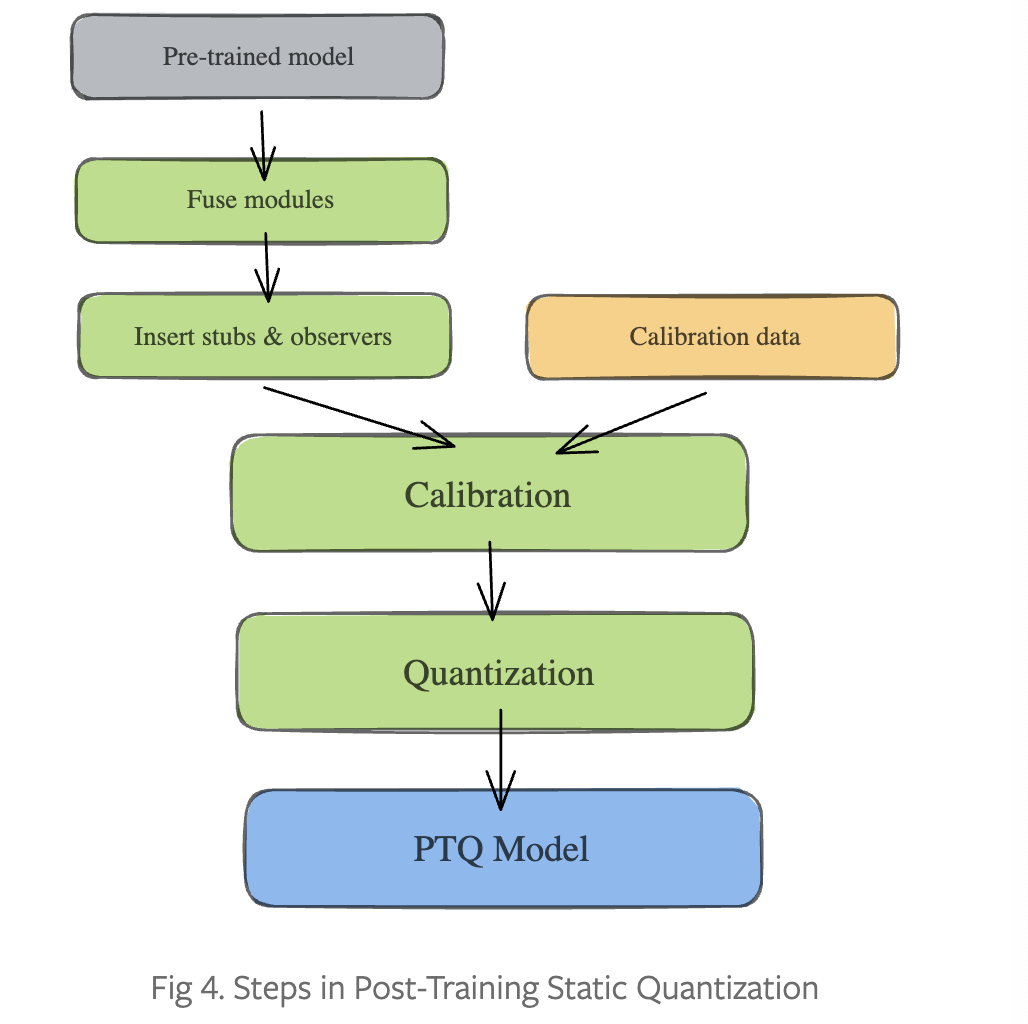

There are many ways of quantization, there is PTQ, post training quantiation and QAT, quantization aware training. Here we're going to focus on PTQ. Another quantization is static quantization. In static Q both model weights and activations are quantized and inference in low-precision. Static quantization supports Conv2d, linear and Relu layer. With static quantization we need to perform a calibration step. 

During this step we're going to quantize both weight and activations and collect states using a calibration dataset. Weights are quantized using symmetric q, explained later, and activation using asymmetric q, these values will be in int8 format. Bias is computed from quantized weights and activations. 

# Calibration 

You need to run the model on representative data to capture activation ranges. During calibration you run a few forward passes on a sample input data (no labels needed) and observe the activation range to determin the min/max ranges. We're going to need these values to compute scale and zero-point. 

Here you see 

    self.quant = torch.quantization.QuantStub()

this tells the model where to quantize. During the preparation phase, later called as prepare(), an observer is attached to QuantStub() to collect statistics on incoming data. They're used for calibration later. 

You also see 

    - self.dequant = torch.quantization.DeQuantStub()

which indicate where quantized tensor should be converted back to floating point. 

Let's use the ame model but encapsulate layers into one to make it easier to fuse layer later. 

In [247]:
# Device configuration
device = torch.device("cpu")
batch_size = 128

# MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset  = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [249]:
# 1. Define a quantizable CNN with fused modules
class QuantizableCNN(nn.Module):
    def __init__(self):
        super(QuantizableCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, bias=False),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, bias=False),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(9216, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, num_labels)

        # Quant stubs
        self.quant = torch.quantization.QuantStub()
        self.dequant = torch.quantization.DeQuantStub()

    def forward(self, x):
        x = self.quant(x)
        x = self.conv(x)
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.dequant(x)
        return x

model_fp32 = QuantizableCNN()

# Hyperparameters
learning_rate = 0.001
num_epochs = 4  # For demonstration

# Train it
model_fp32.train()
for epoch in range(num_epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")


Epoch 1/4, Loss: 0.2821
Epoch 2/4, Loss: 0.1381
Epoch 3/4, Loss: 0.0862
Epoch 4/4, Loss: 0.1115
Full-precision test accuracy: 96.05%


In [281]:
# Prepare model for static quantization
model_fp32.eval()
orig_acc = evaluate(model_fp32, test_loader)
print(f"Full-precision test accuracy: {orig_acc * 100:.2f}%")


Full-precision test accuracy: 10.29%


Here we're going to add a quatizer on the input and a dequtize at the last layer. It's not used until calibration step. 

# Layer fusion 

Let's talk about layer fusion for a bit. With layer fusion we can combine operation like conv2d, batchnorm and relu into one single step. This reduces the memory access and can improve performance on CPUs. Here we're saying fuse CNN and batch norm together. This is a bit more complicated that you need to do though, so we can just skip it and go to the next cell. 

Say we had a batch norm too, here's how fusing might look like

Say a convolution is 

     y = conv(x; W, b) = Wx + b 

and batch norm is 

    bn(y) = γ * (y - μ) / √(σ² + ε) + β

    plug y = Wx + b 

If you fuse the weights you get,  

    W_fused = γ / √(σ² + ε) * W
    b_fused = γ / √(σ² + ε) * (b - μ) + β

Now we don't need batch norm at inference, we just have these new weights and biases. 


In [253]:
model_fp32_fused = torch.quantization.fuse_modules(
    model_fp32,
    [['conv.0', 'conv.1'], ['conv.2',  'conv.3']],
    inplace=False
)

Notice the name of the layer is changed to ConvReLU2d. Here's what it looks like under the hood. You can see the fused blocked conv.0 and conv.1


In [256]:
for name, module in model_fp32_fused.named_modules():
    print(name, module)

 QuantizableCNN(
  (conv): Sequential(
    (0): ConvReLU2d(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (1): ReLU()
    )
    (1): Identity()
    (2): ConvReLU2d(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (1): ReLU()
    )
    (3): Identity()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (quant): QuantStub()
  (dequant): DeQuantStub()
)
conv Sequential(
  (0): ConvReLU2d(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
  )
  (1): Identity()
  (2): ConvReLU2d(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
  )
  (3): Identity()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
conv.0 ConvReLU2d(
  (0): Conv2d(1, 32, kernel_si


Now we needd to tell pytorch how to quantize the model .What observer to use to track min/max values, how to quantize, per tensor, per channel, symmetric or asymmetric, and how to "fake quantize". I know it's a lot of things we haven't covered. We'll go through them later. Here we're saying use fbgemm backend for static quantization default. It supports per channel wight quantization and asymmetric quantization. 

Then we need to prep the model with fake-quant ops which will collect statics from our calibration set. What prepare does it adds these fake quantization observers to the layers. It collects statistics that we need for inference. 

Let's talk a bit symmetric and asymmetric quantization. When you quantize a value r into q you do it with where q is clamed into [q_min and q_max] range 

    q = round(r/s + z ) 

# Asymmetric Quantization 

This allows you to shift you zero point so that the real range [r_min, r_max] spans the integer range as well. Note how you need two parameters to keep track of because the zero point really maps what your data dynamic range shows. 

    - scale = (r_max - r_min)/(q_max - q_min)
    - z = round(q_min - (r_min/s) )
    - q = clip(round(r/s + z), q_min, q_max) 
    - dq = s * (q - z ) 

# Symmetric quantization

Here zero point sits at the integer midpoint. We use maximum absolute range 

    - r_maxabs = max(abs(r_min), abs(r_max))
    - s = r_maxabs/q_max 
    - z = 0 
    - q = clip(round(r/s), q_min, q_max)
    - dq = s * q 

Asymmetric quantization is more flexible especially if your data range is not symmetric. Symmetric is simpler, less parameters, and is more commonly done on weights. 

The following default would apply Asymmetric quantization to activation and symmetric to weights. 

During preapre, nothing is quantized. Observers are inserted to collect stats. 

There are a few backends. FBGEMM :  Facebook GEneral Matrix Multiplication and qnnpack

The get_default_qconfig() is for post-training static quantization and it requiers calibration set to collect activation statistics. 

In [259]:
# Specify quantization config
model_fp32_fused.qconfig = torch.quantization.get_default_qconfig('fbgemm')
model_fp32_fused_qunat=  torch.quantization.prepare(model_fp32_fused, inplace=False)

Let's collect statistic from our training set. Typically this is done using a calibration set that captures all classes and input variation, we're just going to use the training loader. We're going to collect statistics now on the fused-layer model. 

Before we convert it, Let's add a hook and look at the statistics gathered by the original model.

This line grabs the observer object if it exist. 

    obs = getattr(module, "activation_post_process", None)

When you call 

    torch.quantization.prepare(model_fp32, inplace=True)

This inserts fake-quantization observers on each quantiable activation tensors and weights. By convention they are stored in "activation_post_process"  and records min/max or histogram and has methods like .min_val and .max_val and .calculate_qparams() that you can use to compute scale and zero point. 

Notice "intrinsic". This defines fused version of common layer sequences like 

    ConvReLU2d
    ConvBn2d
    ConvBnReLU2d
    LinearReLU

They're just standard layers with fused functionality. 

In [263]:
import torch.nn.intrinsic as nni

def make_calib_hook(layer_name):
    # This function returns the real hook
    def hook(module, inp, out):
        obs = getattr(module, "activation_post_process", None)
        if obs is None:
            return
        lo, hi = obs.min_val, obs.max_val
        scale, zp = obs.calculate_qparams()
        scale, zp = scale.item(), zp.item()
        print(f"[{layer_name}]")
        print(f"  Min / Max  = ({lo:.6f}, {hi:.6f})")
        print(f"  Scale / ZP = ({scale:.6f}, {zp})\n")
    return hook

Every time you add a hook it stays on. We can remove them like this. 

In [266]:
for m in model_fp32_fused_qunat.modules():
    # Clear forward hooks
    if hasattr(m, "_forward_hooks"):
        m._forward_hooks.clear()
    # (Similarly for backward or pre-forward hooks, if needed)
    if hasattr(m, "_backward_hooks"):
        m._backward_hooks.clear()
    if hasattr(m, "_forward_pre_hooks"):
        m._forward_pre_hooks.clear()

Running calibration 

In [269]:
# Attach to your fused ConvReLU2d (or ConvBnReLU2d) modules
for name, module in model_fp32_fused_qunat.named_modules():
    if isinstance(module, (nni.ConvReLU2d, nni.ConvBnReLU2d)):
        # Call make_calib_hook(name) to get a 3-arg function
        module.register_forward_hook(make_calib_hook(name))


# Calibration step 

In [272]:
# Then run your calibration loop
model_fp32_fused_qunat.eval()
with torch.no_grad():
    for i, (images, _) in enumerate(train_loader):
        _ = model_fp32_fused_qunat(images)
        if i >= 100:
            break

[conv.0]
  Min / Max  = (0.000000, 3.472572)
  Scale / ZP = (0.025247, 0)

[conv.2]
  Min / Max  = (0.000000, 1.374570)
  Scale / ZP = (0.009322, 0)

[conv.0]
  Min / Max  = (0.000000, 3.472572)
  Scale / ZP = (0.024419, 0)

[conv.2]
  Min / Max  = (0.000000, 1.374570)
  Scale / ZP = (0.009317, 0)

[conv.0]
  Min / Max  = (0.000000, 3.544932)
  Scale / ZP = (0.025269, 0)

[conv.2]
  Min / Max  = (0.000000, 1.374570)
  Scale / ZP = (0.009312, 0)

[conv.0]
  Min / Max  = (0.000000, 3.544932)
  Scale / ZP = (0.025242, 0)

[conv.2]
  Min / Max  = (0.000000, 1.374570)
  Scale / ZP = (0.009312, 0)

[conv.0]
  Min / Max  = (0.000000, 3.602144)
  Scale / ZP = (0.025247, 0)

[conv.2]
  Min / Max  = (0.000000, 1.374570)
  Scale / ZP = (0.009322, 0)

[conv.0]
  Min / Max  = (0.000000, 3.602144)
  Scale / ZP = (0.025247, 0)

[conv.2]
  Min / Max  = (0.000000, 1.374570)
  Scale / ZP = (0.009312, 0)

[conv.0]
  Min / Max  = (0.000000, 3.602144)
  Scale / ZP = (0.025275, 0)

[conv.2]
  Min / Max  = (

Because we fused Relu, the min value is zero, no negative activation survived. You can see the statistics for each conv blocks. You can see the larger activiation for block 1 are around 4.3. Using these values we can calculate the scale using, 

    scale = 4.3 - 0 / (127 - 1) ~ 0.03

And the zero point is zero. Well you might say that's odd, I thought symmetric qunatization had a zero point of zero and activation should have been asymmetric. That just happens because of the relu activation. 

     s = r_max - r_min / 255
     z = round(-r_min /s) # relu make r_min 0 

The final step is to convert the quantized model 

In [274]:
quantized_model = torch.quantization.convert(model_fp32_fused_qunat, inplace=False)
# Prepare model for static quantization
quantized_model.eval()
orig_acc = evaluate(quantized_model, test_loader)
print(f"Full-precision test accuracy: {orig_acc * 100:.2f}%")

Full-precision test accuracy: 9.80%


In [277]:
model_fp32.eval()
orig_acc = evaluate(model_fp32, test_loader)
print(f"Full-precision test accuracy: {orig_acc * 100:.2f}%")

Full-precision test accuracy: 10.29%


let's take a look at one of the layers 

In [131]:
print(quantized_model.fc1.weight())

tensor([[ 3.1044e-03, -7.7609e-03,  1.1437e-03,  ...,  5.2284e-03,
          3.9213e-03,  5.1467e-03],
        [ 1.6339e-03, -8.1695e-05,  7.9244e-03,  ...,  2.4508e-03,
         -5.9637e-03,  1.0375e-02],
        [ 9.8020e-03, -9.4752e-03, -1.0210e-02,  ...,  4.4926e-03,
          9.8837e-03, -4.9827e-03],
        ...,
        [ 4.0848e-03,  1.0375e-02,  5.3919e-03,  ..., -5.0651e-03,
          1.3071e-03,  3.8397e-03],
        [-1.2255e-03, -8.0881e-03, -8.1698e-05,  ...,  7.8431e-03,
         -5.8006e-03,  3.9215e-03],
        [-5.6367e-03,  1.1437e-03, -4.0029e-03,  ...,  6.6170e-03,
         -1.7972e-03, -2.0423e-03]], size=(128, 9216), dtype=torch.qint8,
       quantization_scheme=torch.per_channel_affine,
       scale=tensor([8.1694e-05, 8.1695e-05, 8.1683e-05, 8.1696e-05, 8.1691e-05, 8.1692e-05,
        8.1683e-05, 8.1695e-05, 8.1689e-05, 8.1698e-05, 8.1696e-05, 8.1694e-05,
        8.1680e-05, 8.1684e-05, 8.1688e-05, 8.1697e-05, 8.1667e-05, 8.1692e-05,
        8.1698e-05, 8.169

Well that's not great! Typically PTQ requier fine-tuning afterward as well, however pytorch does not support training that, the params are not trainable. 

In [142]:
for m in model_fp32.modules():
    # Clear forward hooks
    if hasattr(m, "_forward_hooks"):
        m._forward_hooks.clear()
    # (Similarly for backward or pre-forward hooks, if needed)
    if hasattr(m, "_backward_hooks"):
        m._backward_hooks.clear()
    if hasattr(m, "_forward_pre_hooks"):
        m._forward_pre_hooks.clear()

In [144]:
# Compare model sizes
original_size = get_model_size(model_fp32)
quantized_size = get_model_size(quantized_model)

# Compare inference speeds
original_time = measure_inference_time(model_fp32, images)
quantized_time = measure_inference_time(quantized_model, images)

print(f"original_size {original_size}")
print(f"quantized_size {quantized_size}")
print(f"original_time {original_time}")
print(f"quantized_time {quantized_time}")


original_size 4.849205
quantized_size 1.212789
original_time 0.020498580932617187
quantized_time 0.010902020931243896


In [146]:
# Set the model back to training mode
quantized_model.train()

for param in quantized_model.parameters():
    param.requires_grad = True

# Inspect the parameters of the model after conversion
for name, param in quantized_model.named_parameters():
    print(f"Parameter: {name}, requires_grad: {param.requires_grad}")

# QAT 

In [ ]:
# Set up QAT
model_fp32.train()
torch.quantization.prepare_qat(model_fp32, inplace=True)

# Fine-tune the model using your training data
for epoch in range(10):  # More epochs for QAT
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model_fp32(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")


# Convert to quantized model after QAT
model_qat = torch.quantization.convert(model_fp32, inplace=False)

In [ ]:
# Prepare model for static quantization
model_qat.eval()
orig_acc = evaluate(model_qat, test_loader)
print(f"Full-precision test accuracy: {orig_acc * 100:.2f}%")

# Weight Quantization 

Once you ran the prepare and calibration step, every quantized layer will have a weight_fake_quant attached to it. You can inspect them to see the statistics.  Even though the weights don't change, we still need to collect stats o nthen. Let's see if we can find the weight observers which are used to properly quantize the weights. Reminder that weights are quantized using symmetric q. In our current setting each channel would gets its own scale and zero point. Pytorch does this using special module called "weight_fake_quant". It doesn't actually convert the weight to int8, but record the range of the weights, calculates scale and zero point, and applies fake quantization. 

     w_fake = dquant(quant(w)) = scale * (round(w/scale) + zp)

With PTQ the observers are only used during calibration. 

In [ ]:
model_fp32.qconfig = torch.quantization.get_default_qconfig('fbgemm')
torch.quantization.prepare(model_fp32, inplace=True)

for name, module in model_fp32.named_modules():
    # List all attributes for debugging
    attrs = [a for a in module.__dict__.keys() if "fake_quant" in a.lower()]
    if attrs:
        print(f"\nModule: {name} ({module.__class__.__name__})")
        for attr in attrs:
            obs = getattr(module, attr)
            lo, hi = obs.min_val, obs.max_val
            scale, zp = obs.calculate_qparams()
            print(f"  Observer attr: {attr}")
            print(f"    Min / Max    = ({lo:.6f}, {hi:.6f})")
            print(f"    Scale / ZP   = ({scale.item():.6f}, {zp.item()})")
